In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from stochastic_simulation import StochasticSimulation

In [2]:
import numpy as np
from scipy.stats import poisson

def E_dist(max_time, mean_time):
    pmf = list()
    for i in range(1, max_time):
        pmf.append(poisson.pmf(i, mean_time))
    pmf.append(1-np.sum(pmf))
    return np.array(pmf)

holding_time_1 = E_dist(1, 1)

holding_time_3 = E_dist(8,3)

params = {
    'max_time_exposed': 1,
    'exposed_time_function': (lambda n: np.random.multinomial(n, holding_time_1)),
    
    'max_time_pre_ID': 2,
    'pre_ID_time_function': (lambda n: np.random.multinomial(n, np.array([0.8, 0.2]))),
    
    'max_time_ID': 10,
    'ID_time_function': (lambda n: np.random.multinomial(n, [0]*3+[1/7]*7)),
    
    'sample_QI_exit_function': (lambda n: np.random.binomial(n, 0.05)),
    'sample_QS_exit_function': (lambda n: np.random.binomial(n, 0.3)),
    
    'exposed_infection_p': 0.1,
    'expected_contacts_per_day': 3,
    
    'days_between_tests': 1,
    'test_population_fraction': 1/6,
    'test_protocol_QFNR': 0.1,
    'test_protocol_QFPR': 0.005,
    
    'perform_contact_tracing': False,
    'contact_tracing_constant': None,
    
    'pre_ID_state': 'detectable',
    
    'population_size': 34000,
    'initial_E_count': 0,
    'initial_pre_ID_count': 10,
    'initial_ID_count': 0
}



In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 12

def add_plot(df, params, color='blue'):
    cols = ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
            ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])]
    plt.plot(df[cols].sum(axis=1), linewidth=10.0, alpha=0.1, color=color)    


# just need params to get the proper column names
def plot_sims(dfs1, dfs2, params):
    plt.figure(figsize=(20,12))

    plt.subplot(2,1,1)

    for df in dfs1:
        add_plot(df, params)

    plt.subplot(2,1,2)

    for df in dfs2:
        add_plot(df, params, color='green')

    plt.show()

In [4]:
sim_cts_test = StochasticSimulation(params)
dfs_cts_test = []
for _ in range(100):
    dfs_cts_test.append(sim_cts_test.run_new_trajectory(250))

In [5]:
params_bucketed_test = params.copy()
params_bucketed_test['days_between_tests'] = 6
params_bucketed_test['test_population_fraction'] = 1

sim_bucket_test = StochasticSimulation(params_bucketed_test)
dfs_bucket_test = []
for _ in range(100):
    dfs_bucket_test.append(sim_bucket_test.run_new_trajectory(250))

# Assuming that individuals stay in the 'Exposed' state for exactly one day, the 6-day test frequency is sufficient for mitigating an outbreak, assuming the "bucket approach" where everyone is tested every 6 days

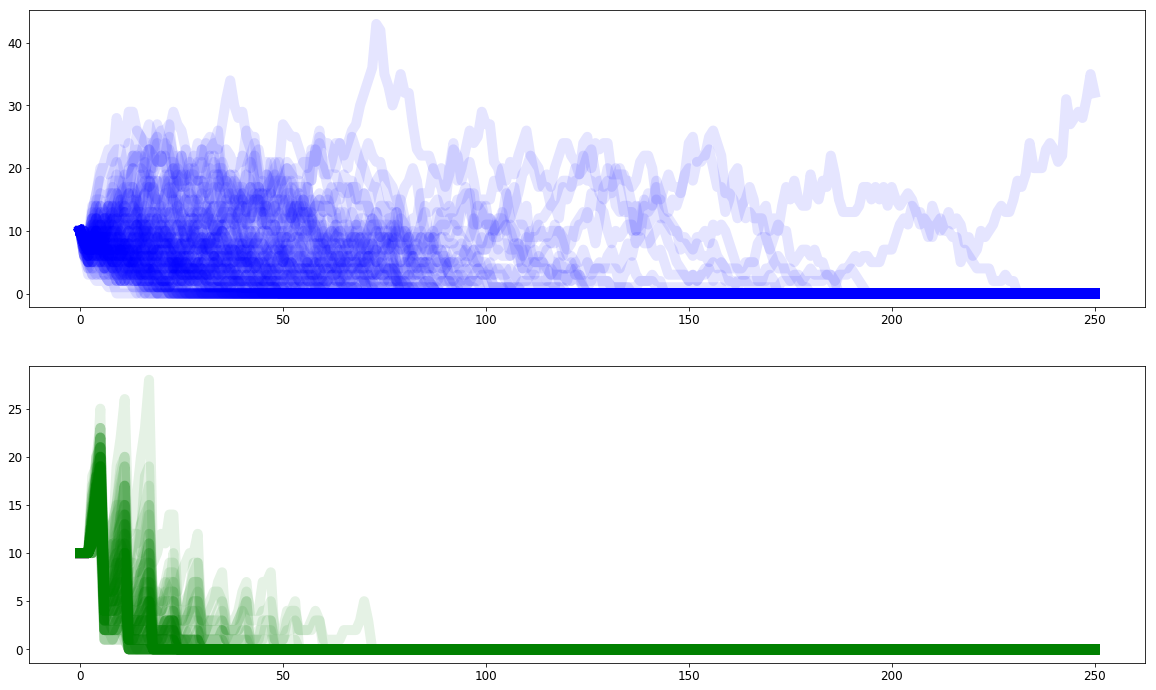

In [6]:
plot_sims(dfs_cts_test, dfs_bucket_test, params)

In [7]:
params_E_3 = params.copy()
params_E_3['max_time_exposed'] = 8
params_E_3['exposed_time_function'] = lambda n: np.random.multinomial(n, holding_time_3)

sim_E_3_cts_test = StochasticSimulation(params_E_3)
dfs_E_3_cts_test = []
for _ in range(100):
    dfs_E_3_cts_test.append(sim_E_3_cts_test.run_new_trajectory(250))

In [8]:
params_bucket_E_3 = params_E_3.copy()
params_bucket_E_3['days_between_tests'] = 6
params_bucket_E_3['test_population_fraction'] = 1

sim_bucket_E_3 = StochasticSimulation(params_bucket_E_3)
dfs_bucket_E_3 = []
for _ in range(100):
    dfs_bucket_E_3.append(sim_bucket_E_3.run_new_trajectory(250))

# On the other hand, changing the distribution of time spent in the 'E' state from deterministically 1 day to stochastic Poisson(3) days (capped at 8 days), a major outbreak occurs under both testing protocols 

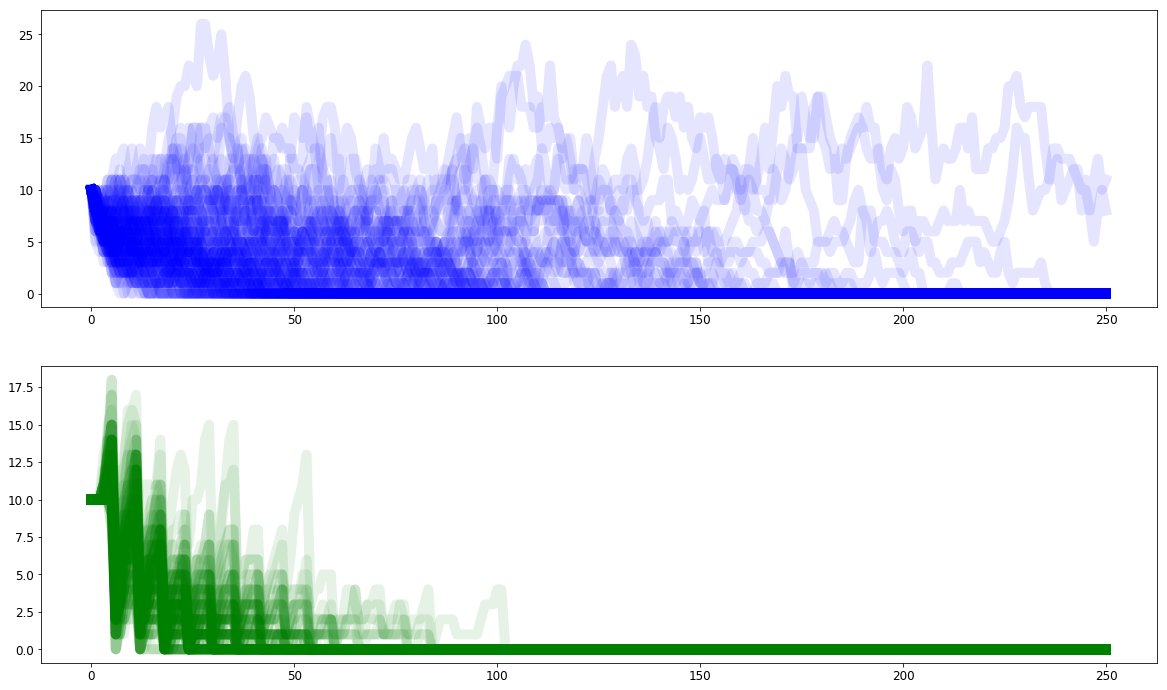

In [9]:
plot_sims(dfs_E_3_cts_test, dfs_bucket_E_3, params)

# A note on analyzing this data: trajectories are dataframes; each row gives counts of people in each state on each day

In [21]:
# all of the trajectories created above are lists of data frames.  
# Data frames are designed to be easy to analyze.

trajectory_df = dfs_bucket_E_3[0]
trajectory_df.head(n=10)

,S,QS,QI,R,E_0,E_1,E_2,E_3,E_4,E_5,...,ID_0,ID_1,ID_2,ID_3,ID_4,ID_5,ID_6,ID_7,ID_8,ID_9
0,33990,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,33990,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,2,0,1,2
2,33969,0,0,0,6,4,2,5,2,1,...,0,0,0,2,1,3,0,1,2,1
3,33937,0,0,0,11,9,18,6,5,1,...,0,0,2,1,3,0,1,2,1,0
4,33897,0,0,0,13,32,14,14,8,5,...,0,2,1,3,0,1,2,1,0,0
5,33847,0,0,0,39,28,31,18,13,4,...,2,1,3,0,1,2,2,0,0,0
6,33714,123,27,0,30,33,28,23,6,6,...,0,1,0,0,0,0,0,0,0,0
7,33732,94,26,1,35,34,35,15,10,5,...,1,0,0,0,1,1,0,1,0,0
8,33744,59,24,4,41,47,28,17,11,8,...,0,0,0,3,1,1,1,0,0,0
9,33749,43,23,5,51,39,33,22,10,2,...,0,0,3,2,1,1,0,0,1,0


# notice that a huge buildup accumulates in the E queue before any major buildup occurs in the ID queue 

In [22]:
trajectory_df.head(n=30)

,S,QS,QI,R,E_0,E_1,E_2,E_3,E_4,E_5,...,ID_0,ID_1,ID_2,ID_3,ID_4,ID_5,ID_6,ID_7,ID_8,ID_9
0,33990,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,33990,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,2,0,1,2
2,33969,0,0,0,6,4,2,5,2,1,...,0,0,0,2,1,3,0,1,2,1
3,33937,0,0,0,11,9,18,6,5,1,...,0,0,2,1,3,0,1,2,1,0
4,33897,0,0,0,13,32,14,14,8,5,...,0,2,1,3,0,1,2,1,0,0
5,33847,0,0,0,39,28,31,18,13,4,...,2,1,3,0,1,2,2,0,0,0
6,33714,123,27,0,30,33,28,23,6,6,...,0,1,0,0,0,0,0,0,0,0
7,33732,94,26,1,35,34,35,15,10,5,...,1,0,0,0,1,1,0,1,0,0
8,33744,59,24,4,41,47,28,17,11,8,...,0,0,0,3,1,1,1,0,0,0
9,33749,43,23,5,51,39,33,22,10,2,...,0,0,3,2,1,1,0,0,1,0


# Does using geometric holding time, instead of Poisson, change the outcome

In [23]:
from scipy.stats import geom
def E_dist_geom(max_time, mean_time):
    pmf = list()
    for i in range(1, max_time):
        pmf.append(geom.pmf(i, 1/mean_time))
    pmf.append(1-np.sum(pmf))
    return np.array(pmf)

holding_time_3_geom = E_dist_geom(8, 3)

In [24]:
params_bucket_E_3_geom = params_bucket_E_3.copy()
params_bucket_E_3_geom['exposed_time_function'] = lambda n: np.random.multinomial(n, holding_time_3_geom)

sim_bucket_E_3_geom = StochasticSimulation(params_bucket_E_3_geom)
dfs_bucket_E_3_geom = []
for _ in range(100):
    dfs_bucket_E_3_geom.append(sim_bucket_E_3_geom.run_new_trajectory(250))

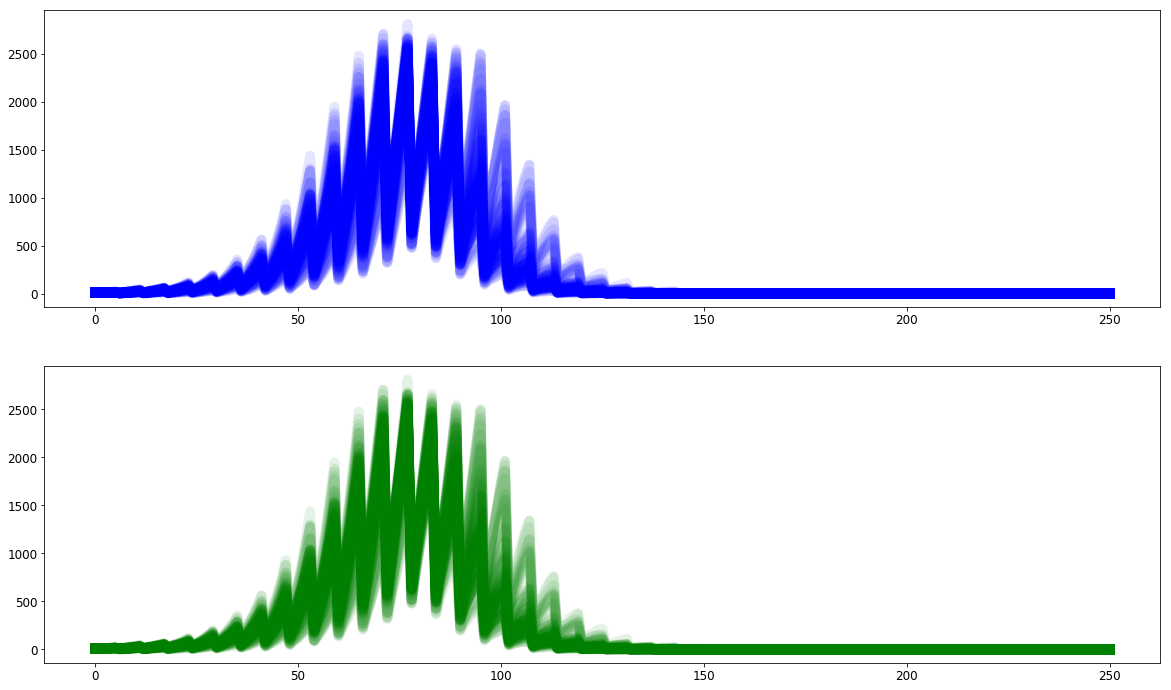

In [25]:
plot_sims(dfs_bucket_E_3_geom, dfs_bucket_E_3_geom, params)

In [27]:
dfs_bucket_E_3_geom[0]

,S,QS,QI,R,E_0,E_1,E_2,E_3,E_4,E_5,...,ID_0,ID_1,ID_2,ID_3,ID_4,ID_5,ID_6,ID_7,ID_8,ID_9
0,33990,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,33990,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,3,0,0,3
2,33965,0,0,0,9,7,2,5,0,1,...,0,0,2,1,0,4,0,0,3,0
3,33940,0,0,0,19,8,9,6,1,4,...,0,2,1,0,4,0,0,3,0,0
4,33915,0,0,0,17,25,11,7,6,2,...,2,1,0,4,0,0,3,0,0,0
5,33879,0,0,2,39,22,17,10,11,1,...,1,0,4,0,0,3,1,0,1,1
6,33757,119,14,6,33,24,13,14,6,6,...,0,0,0,0,0,0,0,0,1,0
7,33789,76,13,7,41,22,20,10,7,5,...,0,0,0,1,0,1,0,2,0,0
8,33810,53,11,9,37,27,17,12,7,5,...,0,0,1,0,1,0,2,0,2,0
9,33813,41,10,10,40,22,19,14,9,5,...,0,1,0,1,0,2,1,3,1,0
